### How to push to github
##### Write the following in the git terminal:
##### git add *
##### git commit -m "Write the changes in the file that were done here"
##### git push

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import kn
from scipy.integrate import quad
import csv

In [5]:
"""
with open('Gstar.csv', 'r') as f:
    Gstarreader = csv.reader(f)
    Gstardata = {float(row[0]): float(row[1]) for row in Gstarreader}

with open('GstarS.csv', 'r') as f:
    GstarSreader = csv.reader(f)
    GstarSdata = {float(row[0]): float(row[1]) for row in GstarSreader}
"""

"\nwith open('Gstar.csv', 'r') as f:\n    Gstarreader = csv.reader(f)\n    Gstardata = {float(row[0]): float(row[1]) for row in Gstarreader}\n\nwith open('GstarS.csv', 'r') as f:\n    GstarSreader = csv.reader(f)\n    GstarSdata = {float(row[0]): float(row[1]) for row in GstarSreader}\n"

<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\s'
C:\Users\press\AppData\Local\Temp\ipykernel_16092\2384608583.py:32: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Log plot of Y(x) for different $\sigma$ values')
C:\Users\press\AppData\Local\Temp\ipykernel_16092\3112628040.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  return (1 / (8 * m**4 * T * kn(2, m / T))) * integral_result
C:\Users\press\AppData\Local\Temp\ipykernel_16092\3112628040.py:16: RuntimeWarning: invalid value encountered in scalar multiply
  return (1 / (8 * m**4 * T * kn(2, m / T))) * integral_result


TestMeson
Frozen-out Y(x) for TestMeson = 9.119001987011913e-06
Cross section of TestMeson = 1e-10


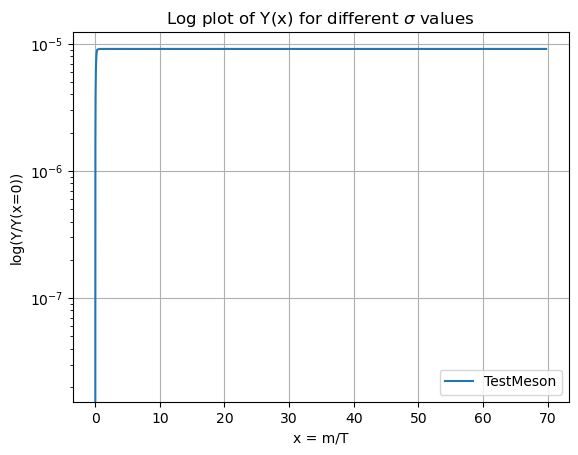

In [68]:
%run FreezeOutFunctions.ipynb
%run CrossSectionFunctions.ipynb

Y0 = [0]  
x_min = 0.01 
x_max = 100 
x_span = (x_min, x_max)
x_eval = np.linspace(x_min, x_max, 500000)

# THE STRING ENCLOSED WITHIN THE "" IS TELLING THE CODE WHAT RATIO TO USE REGARDLESS OF WHAT VARIABLE YOU PASS THROUGH NEXT
sigma_values = {
    "TestMeson": Sigma_Meson,
    #"TestBaryon": Sigma_Baryon
}

for particle, sigma_value in sigma_values.items():
    sol = solve_ivp(lambda x, Y: dYdx(x, Y, sigma_value, particle), x_span, Y0, t_eval=x_eval)
    print(particle)
    
    # Number of frozen-out DM particles
    Y_frozen = sol.y[0, -1]
    print(f'Frozen-out Y(x) for {particle} = {Y_frozen}')
    print(f'Cross section of {particle} = {sigma_value}')
    
    plt.plot(sol.t, sol.y[0], label=f'{particle}')
    
# Plot configurations
plt.yscale('log')  
#plt.xscale('log')  
plt.xlabel('x = m/T')
plt.ylabel('log(Y/Y(x=0))')
plt.title('Log plot of Y(x) for different $\sigma$ values')
plt.legend()
plt.grid(True)
#plt.savefig('DifferentSigmaSValues.png', facecolor='w')

plt.show()

In [20]:
"""
sigma_values = [Sigma_SC_NeutralPion, Sigma_SC_NeutralKaon]

for sigma_value in sigma_values:
    sigma_name = get_variable_name(sigma_value, globals())
    sol = solve_ivp(lambda x, Y: dYdx(x, Y, sigma_value), x_span, Y0, t_eval=x_eval)
        
    # Number of frozen-out dm particles
    Y_frozen = sol.y[0, -1]
    print(f'Frozen-out Y(x) for {sigma_name} = {sigma_value}: {Y_frozen}')
    
    plt.plot(sol.t, sol.y[0], label=f'{sigma_name} = {sigma_value}')
"""

"\nsigma_values = [Sigma_SC_NeutralPion, Sigma_SC_NeutralKaon]\n\nfor sigma_value in sigma_values:\n    sigma_name = get_variable_name(sigma_value, globals())\n    sol = solve_ivp(lambda x, Y: dYdx(x, Y, sigma_value), x_span, Y0, t_eval=x_eval)\n        \n    # Number of frozen-out dm particles\n    Y_frozen = sol.y[0, -1]\n    print(f'Frozen-out Y(x) for {sigma_name} = {sigma_value}: {Y_frozen}')\n    \n    plt.plot(sol.t, sol.y[0], label=f'{sigma_name} = {sigma_value}')\n"

In [55]:
from scipy.integrate import odeint

for x in x_eval:
    y = odeint(dYdx(x,Y,sigma_value,particle),Y0,x_eval)

NameError: name 'Y' is not defined

In [82]:
Y0 = np.array([1.0])
Y = odeint(dYdx, Y0, x_eval, args=(sigma_value, particle))
Y = Y[:, 0]


RuntimeError: The array return by func must be one-dimensional, but got ndim=2.

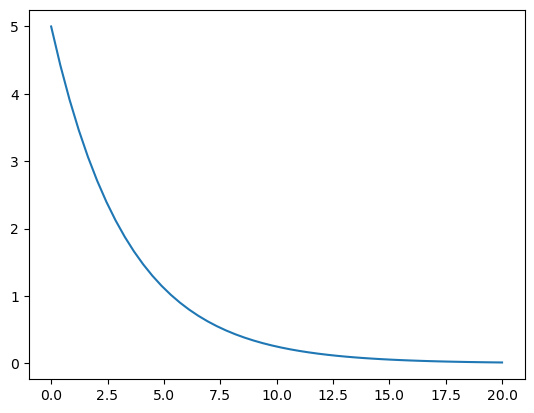

In [88]:
# function that returns dy/dt
def model(y,t):
    k = 0.3
    dydt = -k * y
    return dydt

# initial condition
y0 = 5

# time points
t = np.linspace(0,20)

# solve ODE
y = odeint(model,y0,t)

plt.plot(t,y)